In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

In [ ]:
#importing dataset
dataset_directory = os.listdir('/content/drive/MyDrive/Plant_Village_data/PotatoLeafImage_data')
for filenames in dataset_directory:
    print(filenames)

Potato___Late_blight
Potato___healthy
Potato___Early_blight


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2

In [ ]:
#Global initialization of Image size, Batch size, and Channels variables
Image_Size = 256
Batch_Size = 16
Channels = 3

In [ ]:
dataset_directory = '/content/drive/MyDrive/Plant_Village_data/PotatoLeafImage_data'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,
    batch_size=Batch_Size,
    image_size=(Image_Size, Image_Size),
    shuffle=True

)

Found 2152 files belonging to 3 classes.


In [ ]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

135

In [ ]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    tf.random.set_seed(10)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)

    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_data, val_data, test_data = split_dataset(dataset)

In [ ]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :135 
Batch size of Training Data is :108
Batch size of Validation Data is :13 
Batch size of Testing Data is :14 


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Keras Sequential model for Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
  layers.experimental.preprocessing.RandomContrast(factor=0.2)
])

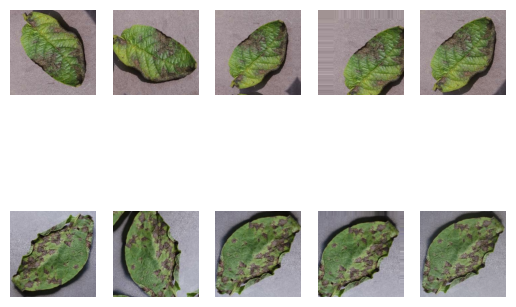

In [ ]:
for images, labels in dataset.take(1):
    # Visualize each augmentation separately for the entire batch
    for i in range(2):
        original_image = images[i].numpy()

        # Reshape the image to (1, height, width, channels) for compatibility with the data augmentation layer
        original_image = np.expand_dims(original_image, axis=0)

        # Apply data augmentation
        for j, augmentation_layer in enumerate(data_augmentation.layers):
            augmented_image = augmentation_layer(original_image)

            # Visualize the augmented image
            plt.subplot(2, len(data_augmentation.layers), i * len(data_augmentation.layers) + j + 1)
            plt.imshow(augmented_image[0].numpy().astype(np.uint8))
            plt.axis('off')

plt.show()

In [ ]:
train_ds = train_data.cache().shuffle(1000).map(
  lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
# Model with dropout 0.2
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model16_DR2 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),   # Dropout before the final dense layer
    layers.Dense(3, activation='softmax')
])
model16_DR2.build(input_shape = input_shape)
model16_DR2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [ ]:
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model16_DR2.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history16_DR2 = model16_DR2.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 182s 308ms/step - loss: 0.9124 - accuracy: 0.4971 - val_loss: 0.8334 - val_accuracy: 0.5048
Epoch 2/200
108/108 [==============================] - 32s 298ms/step - loss: 0.7635 - accuracy: 0.6593 - val_loss: 0.6821 - val_accuracy: 0.6923
Epoch 3/200
108/108 [==============================] - 32s 301ms/step - loss: 0.5707 - accuracy: 0.7884 - val_loss: 1.2770 - val_accuracy: 0.5962
Epoch 4/200
108/108 [==============================] - 32s 297ms/step - loss: 0.4879 - accuracy: 0.8227 - val_loss: 1.0887 - val_accuracy: 0.6490
Epoch 5/200
108/108 [==============================] - 32s 297ms/step - loss: 0.4098 - accuracy: 0.8390 - val_loss: 0.3288 - val_accuracy: 0.8702
Epoch 6/200
108/108 [==============================] - 32s 295ms/step - loss: 0.3762 - accuracy: 0.8547 - val_loss: 0.3391 - val_accuracy: 0.8798
Epoch 7/200
108/108 [==============================] - 32s 295ms/step - loss: 0.3742 - accuracy: 0.8547 - val_loss: 0.4748 

In [ ]:
# Getting the model history to analyse
train_loss = history16_DR2.history['loss']
train_acc = history16_DR2.history['accuracy']

val_loss = history16_DR2.history['val_loss']
val_acc = history16_DR2.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

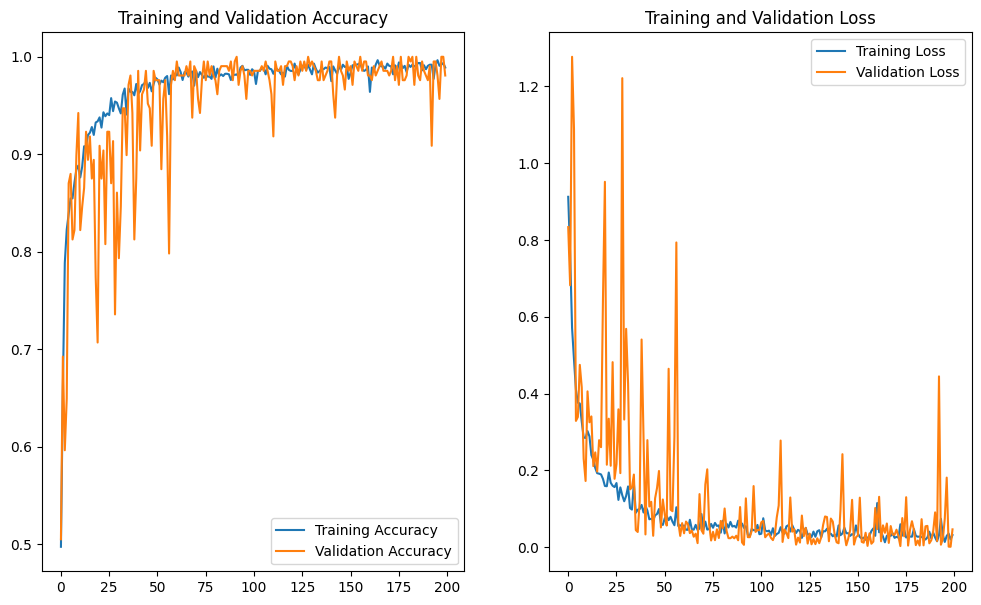

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
model16_DR2.save('/content/drive/My Drive/best_model16_DR2')

In [ ]:
model_path = '/content/drive/My Drive/best_model16_DR2'
CNN_16_DR2_001 = tf.keras.models.load_model(model_path)

In [ ]:
scores = CNN_16_DR2_001.evaluate(test_ds)

14/14 [==============================] - 83s 79ms/step - loss: 0.0765 - accuracy: 0.9821


In [ ]:
predictions = CNN_16_DR2_001.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = []  # empty list to store true labels
for _, y in test_ds:
    true_labels.extend(y.numpy())

# Convert list to numpy array
true_labels = np.array(true_labels)


14/14 [==============================] - 1s 73ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Classification report for precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=['Potato Early Blight', 'Potato Late Blight', 'Potato Healthy'])
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

                     precision    recall  f1-score   support

Potato Early Blight       1.00      1.00      1.00       105
 Potato Late Blight       1.00      0.96      0.98       101
     Potato Healthy       0.82      1.00      0.90        18

           accuracy                           0.98       224
          macro avg       0.94      0.99      0.96       224
       weighted avg       0.99      0.98      0.98       224

[[105   0   0]
 [  0  97   4]
 [  0   0  18]]
Accuracy: 0.9821428571428571


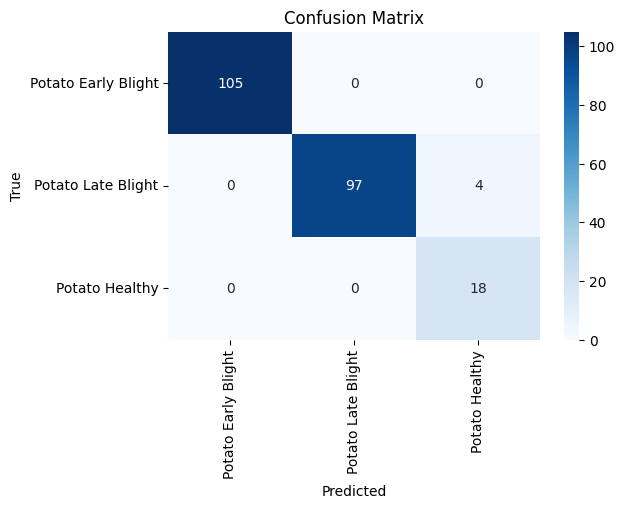

In [ ]:
# Visualize Confusion Matrix
labels = ['Potato Early Blight', 'Potato Late Blight','Potato Healthy']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate AUC-ROC

roc_auc = roc_auc_score(y_binarized, predictions, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')

AUC-ROC: 0.999408329419255


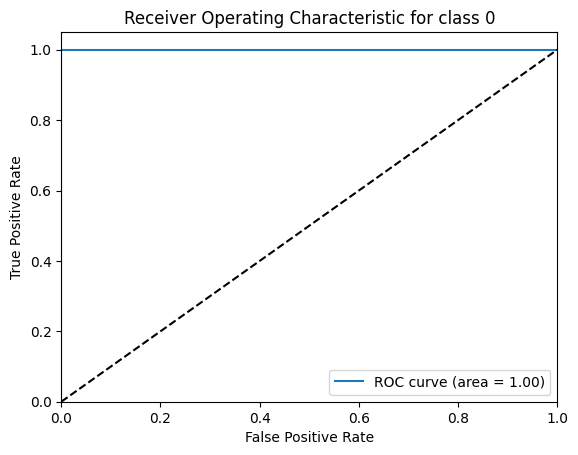

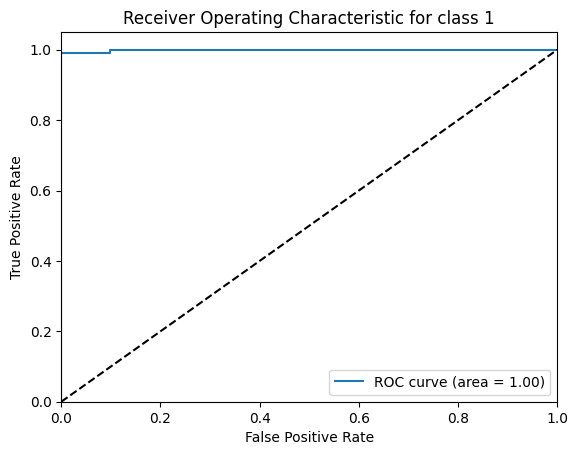

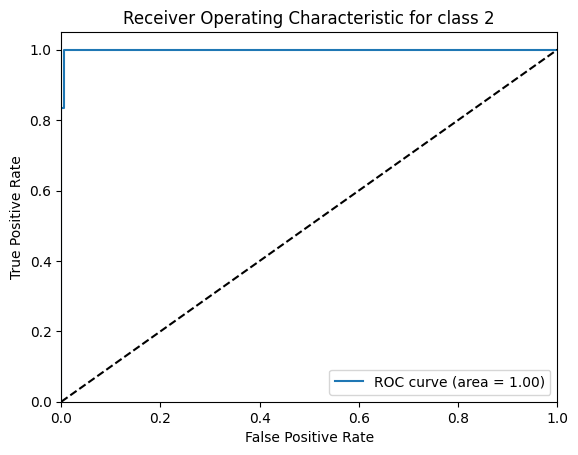

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(y_binarized[:, i], predictions[:, i])

# Plotting
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Model with dropout 0.1
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model16_DR1_001 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(3, activation='softmax')
])
model16_DR1_001.build(input_shape = input_shape)
model16_DR1_001.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [ ]:
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model16_DR1_001.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history16_DR1_001= model16_DR1_001.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 180s 303ms/step - loss: 0.8627 - accuracy: 0.5424 - val_loss: 0.6901 - val_accuracy: 0.7163
Epoch 2/200
108/108 [==============================] - 32s 292ms/step - loss: 0.7153 - accuracy: 0.6977 - val_loss: 1.0620 - val_accuracy: 0.5096
Epoch 3/200
108/108 [==============================] - 31s 291ms/step - loss: 0.5822 - accuracy: 0.7581 - val_loss: 1.0332 - val_accuracy: 0.5962
Epoch 4/200
108/108 [==============================] - 32s 294ms/step - loss: 0.5251 - accuracy: 0.7878 - val_loss: 0.4975 - val_accuracy: 0.7596
Epoch 5/200
108/108 [==============================] - 32s 291ms/step - loss: 0.4258 - accuracy: 0.8244 - val_loss: 0.3061 - val_accuracy: 0.8990
Epoch 6/200
108/108 [==============================] - 31s 291ms/step - loss: 0.3030 - accuracy: 0.8750 - val_loss: 0.4823 - val_accuracy: 0.7981
Epoch 7/200
108/108 [==============================] - 32s 292ms/step - loss: 0.3072 - accuracy: 0.8767 - val_loss: 0.4447 

In [ ]:
# Getting the model history to analyse
train_loss = history16_DR1_001.history['loss']
train_acc = history16_DR1_001.history['accuracy']

val_loss = history16_DR1_001.history['val_loss']
val_acc = history16_DR1_001.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

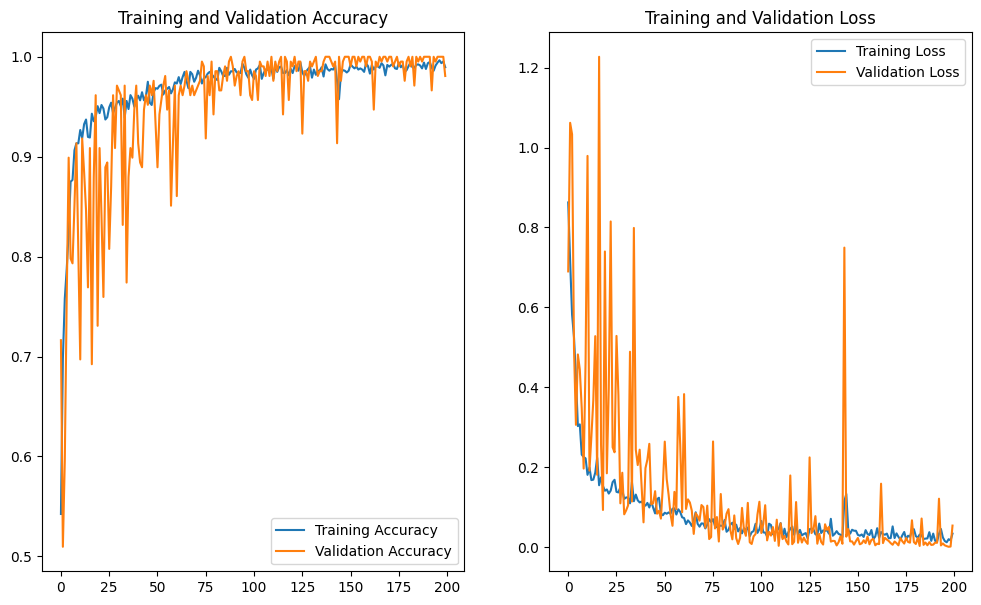

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
model16_DR1_001.save('/content/drive/My Drive/best_model16_DR1_001')

In [ ]:
model_path = '/content/drive/My Drive/best_model16_DR1_001'
CNN_16_DR1_001 = tf.keras.models.load_model(model_path)

In [ ]:
scores = CNN_16_DR1_001.evaluate(test_ds)

14/14 [==============================] - 1s 77ms/step - loss: 0.0254 - accuracy: 0.9911


In [ ]:
predictions = CNN_16_DR1_001.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = []
for _, y in test_ds:
    true_labels.extend(y.numpy())

# Convert list to numpy array
true_labels = np.array(true_labels)

14/14 [==============================] - 1s 73ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Classification report for precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=['Potato Early Blight', 'Potato Late Blight', 'Potato Healthy'])
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

                     precision    recall  f1-score   support

Potato Early Blight       0.99      1.00      1.00       105
 Potato Late Blight       1.00      0.98      0.99       101
     Potato Healthy       0.95      1.00      0.97        18

           accuracy                           0.99       224
          macro avg       0.98      0.99      0.99       224
       weighted avg       0.99      0.99      0.99       224

[[105   0   0]
 [  1  99   1]
 [  0   0  18]]
Accuracy: 0.9910714285714286


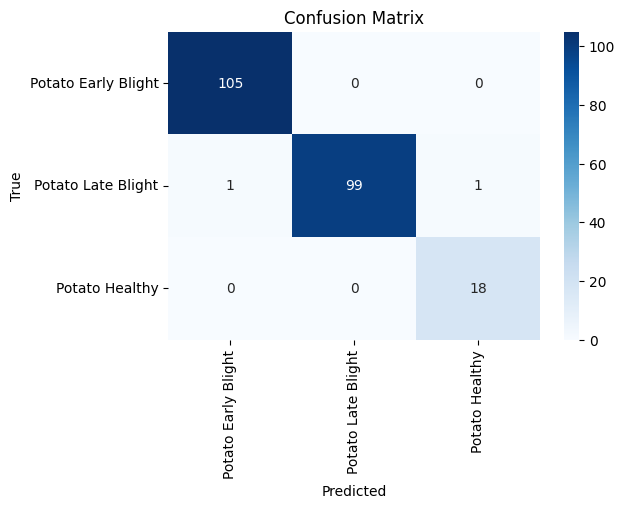

In [ ]:
# Visualize Confusion Matrix
labels = ['Potato Early Blight', 'Potato Late Blight','Potato Healthy']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate AUC-ROC
# The "ovr" means "one versus rest"
roc_auc = roc_auc_score(y_binarized, predictions, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')


AUC-ROC: 1.0


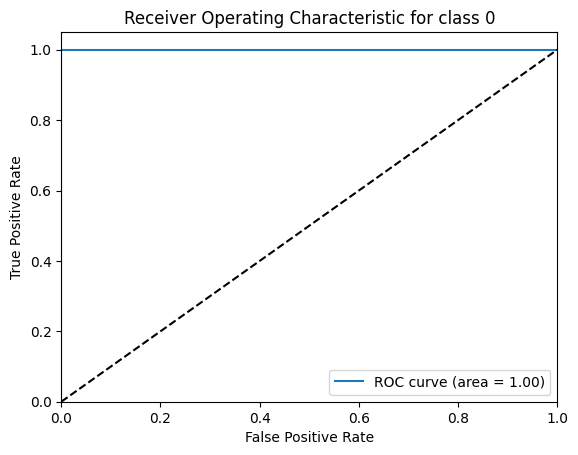

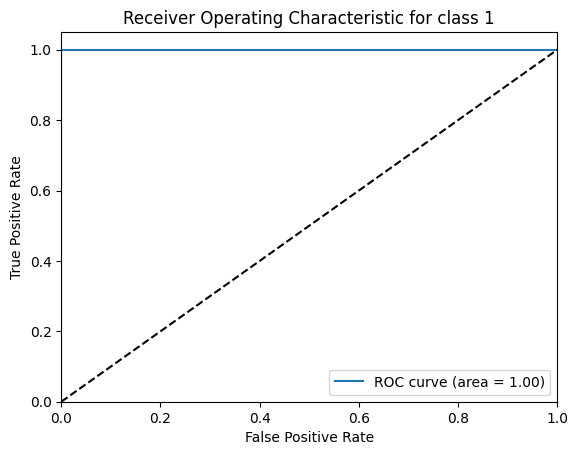

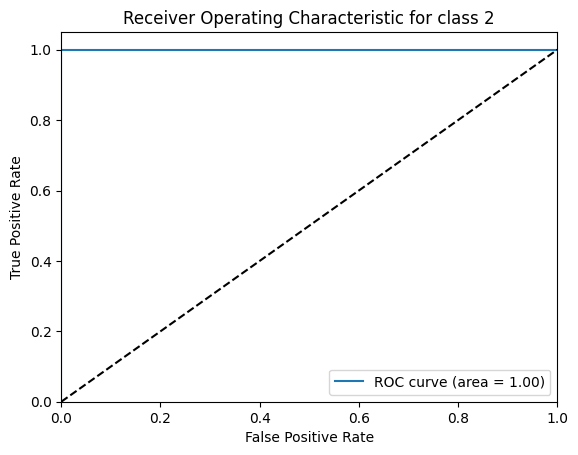

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(y_binarized[:, i], predictions[:, i])

# Plotting
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Model with dropout 0.3
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model16_DR3_001 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])
model16_DR3_001.build(input_shape = input_shape)
model16_DR3_001.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [ ]:
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model16_DR3_001.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history16_DR3_001= model16_DR3_001.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 189s 319ms/step - loss: 0.9276 - accuracy: 0.4942 - val_loss: 0.8634 - val_accuracy: 0.4519
Epoch 2/200
108/108 [==============================] - 33s 306ms/step - loss: 0.7852 - accuracy: 0.6360 - val_loss: 1.1898 - val_accuracy: 0.5288
Epoch 3/200
108/108 [==============================] - 33s 305ms/step - loss: 0.7121 - accuracy: 0.6942 - val_loss: 0.9726 - val_accuracy: 0.6346
Epoch 4/200
108/108 [==============================] - 33s 306ms/step - loss: 0.5461 - accuracy: 0.7837 - val_loss: 0.7517 - val_accuracy: 0.6971
Epoch 5/200
108/108 [==============================] - 33s 307ms/step - loss: 0.4599 - accuracy: 0.8279 - val_loss: 0.5654 - val_accuracy: 0.7837
Epoch 6/200
108/108 [==============================] - 33s 305ms/step - loss: 0.3749 - accuracy: 0.8471 - val_loss: 0.2740 - val_accuracy: 0.8798
Epoch 7/200
108/108 [==============================] - 33s 308ms/step - loss: 0.3483 - accuracy: 0.8558 - val_loss: 1.7435 

In [ ]:
# Getting the model history to analyse
train_loss = history16_DR3_001.history['loss']
train_acc = history16_DR3_001.history['accuracy']

val_loss = history16_DR3_001.history['val_loss']
val_acc = history16_DR3_001.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

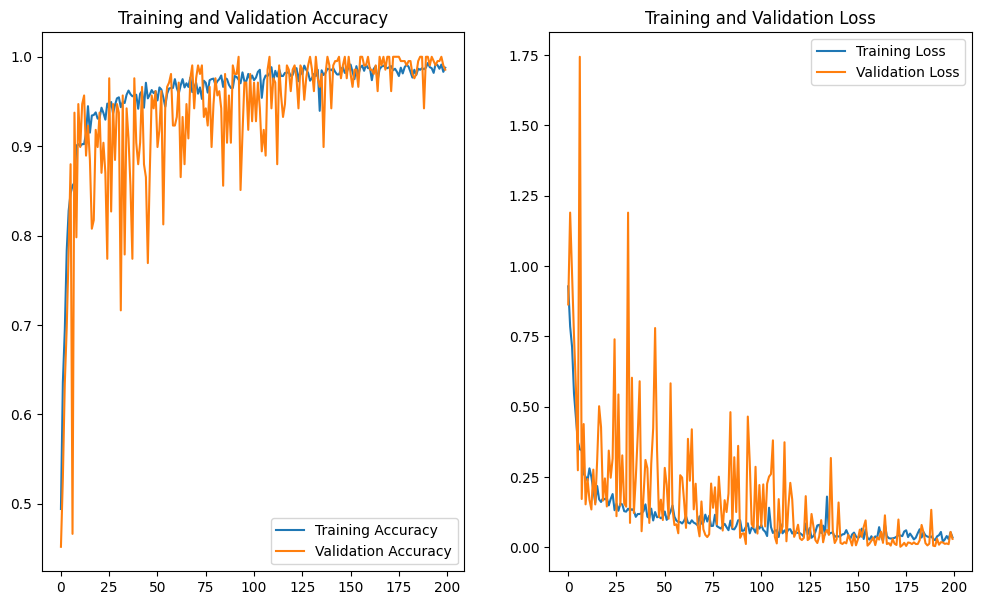

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
model16_DR3_001.save('/content/drive/My Drive/best_model16_DR3_001')

In [ ]:
model_path = '/content/drive/MyDrive/best_model16_DR3_001'
CNN_16_DR3_001 = tf.keras.models.load_model(model_path)

In [ ]:
scores = CNN_16_DR3_001.evaluate(test_ds)

14/14 [==============================] - 1s 75ms/step - loss: 0.0530 - accuracy: 0.9866


In [ ]:
predictions = CNN_16_DR3_001.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = []
for _, y in test_ds:
    true_labels.extend(y.numpy())

# Convert list to numpy array
true_labels = np.array(true_labels)

14/14 [==============================] - 1s 75ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Classification report for precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=['Potato Early Blight', 'Potato Late Blight', 'Potato Healthy'])
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

                     precision    recall  f1-score   support

Potato Early Blight       1.00      1.00      1.00       105
 Potato Late Blight       1.00      0.97      0.98       101
     Potato Healthy       0.86      1.00      0.92        18

           accuracy                           0.99       224
          macro avg       0.95      0.99      0.97       224
       weighted avg       0.99      0.99      0.99       224

[[105   0   0]
 [  0  98   3]
 [  0   0  18]]
Accuracy: 0.9866071428571429


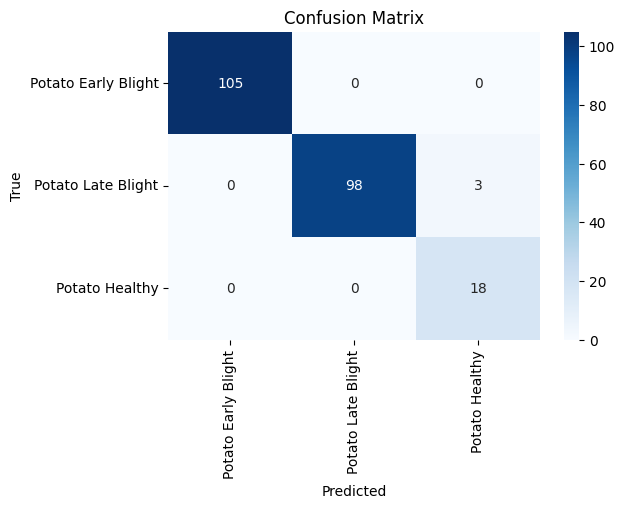

In [ ]:
# Visualize Confusion Matrix
labels = ['Potato Early Blight', 'Potato Late Blight','Potato Healthy']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate AUC-ROC
# The "ovr" means "one versus rest"
roc_auc = roc_auc_score(y_binarized, predictions, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')


AUC-ROC: 0.9994257615042427


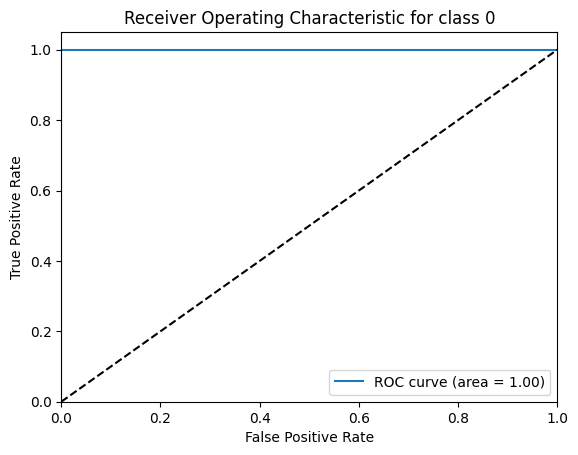

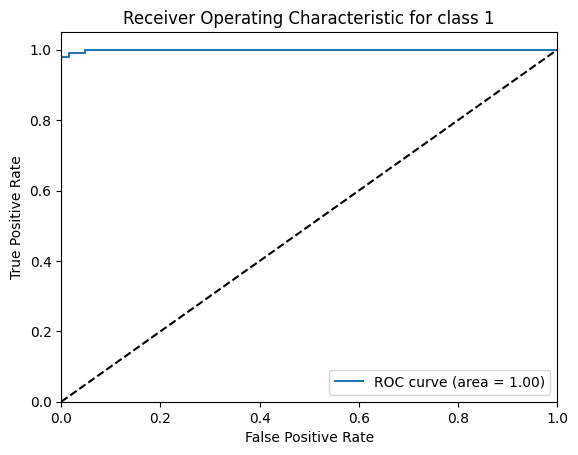

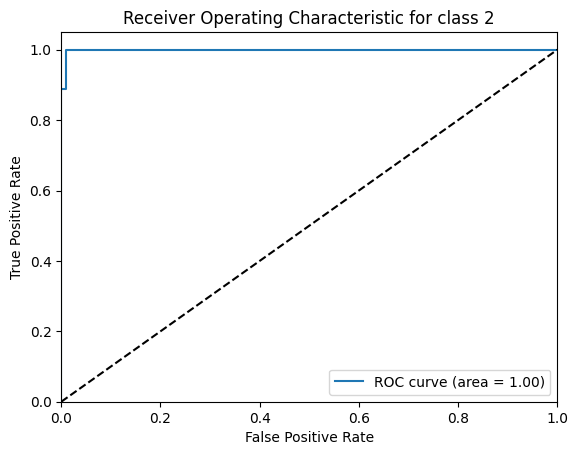

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(y_binarized[:, i], predictions[:, i])

# Plotting
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Model with dropout 0.5
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model16_DR5_001 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])
model16_DR5_001.build(input_shape = input_shape)
model16_DR5_001.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [ ]:
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model16_DR5_001.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history16_DR5_001= model16_DR5_001.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 232s 296ms/step - loss: 0.9165 - accuracy: 0.4733 - val_loss: 0.9793 - val_accuracy: 0.4663
Epoch 2/200
108/108 [==============================] - 31s 284ms/step - loss: 0.7891 - accuracy: 0.6366 - val_loss: 0.7622 - val_accuracy: 0.6875
Epoch 3/200
108/108 [==============================] - 31s 288ms/step - loss: 0.6029 - accuracy: 0.7651 - val_loss: 0.8161 - val_accuracy: 0.6923
Epoch 4/200
108/108 [==============================] - 31s 283ms/step - loss: 0.4938 - accuracy: 0.8174 - val_loss: 1.0672 - val_accuracy: 0.6923
Epoch 5/200
108/108 [==============================] - 31s 286ms/step - loss: 0.4206 - accuracy: 0.8483 - val_loss: 1.3102 - val_accuracy: 0.6298
Epoch 6/200
108/108 [==============================] - 31s 288ms/step - loss: 0.3830 - accuracy: 0.8605 - val_loss: 1.9423 - val_accuracy: 0.5865
Epoch 7/200
108/108 [==============================] - 31s 283ms/step - loss: 0.3704 - accuracy: 0.8645 - val_loss: 0.4122 

In [ ]:
# Getting the model history to analyse
train_loss = history16_DR5_001.history['loss']
train_acc = history16_DR5_001.history['accuracy']

val_loss = history16_DR5_001.history['val_loss']
val_acc = history16_DR5_001.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

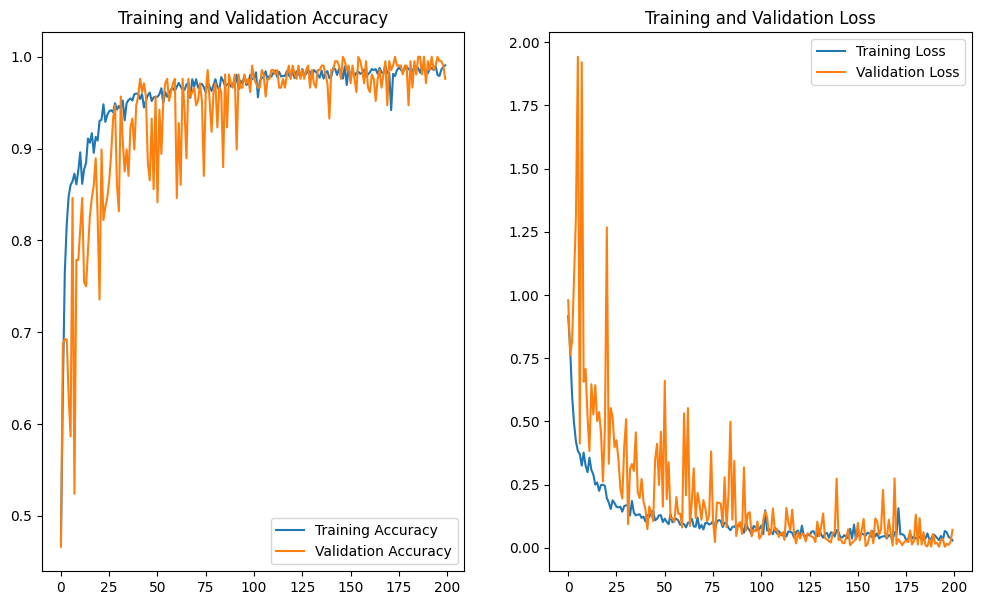

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
model16_DR5_001.save('/content/drive/My Drive/best_model16_DR5')

In [ ]:
model_path = '/content/drive/MyDrive/best_model16_DR5'
CNN_16_DR5_001 = tf.keras.models.load_model(model_path)

In [ ]:
scores = CNN_16_DR5_001.evaluate(test_ds)

14/14 [==============================] - 1s 73ms/step - loss: 0.0648 - accuracy: 0.9777


In [ ]:
predictions = CNN_16_DR5_001.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = []
for _, y in test_ds:
    true_labels.extend(y.numpy())

# Convert list to numpy array
true_labels = np.array(true_labels)

14/14 [==============================] - 1s 72ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Classification report for precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=['Potato Early Blight', 'Potato Late Blight', 'Potato Healthy'])
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

                     precision    recall  f1-score   support

Potato Early Blight       0.96      1.00      0.98       105
 Potato Late Blight       1.00      0.95      0.97       101
     Potato Healthy       0.95      1.00      0.97        18

           accuracy                           0.98       224
          macro avg       0.97      0.98      0.98       224
       weighted avg       0.98      0.98      0.98       224

[[105   0   0]
 [  4  96   1]
 [  0   0  18]]
Accuracy: 0.9776785714285714


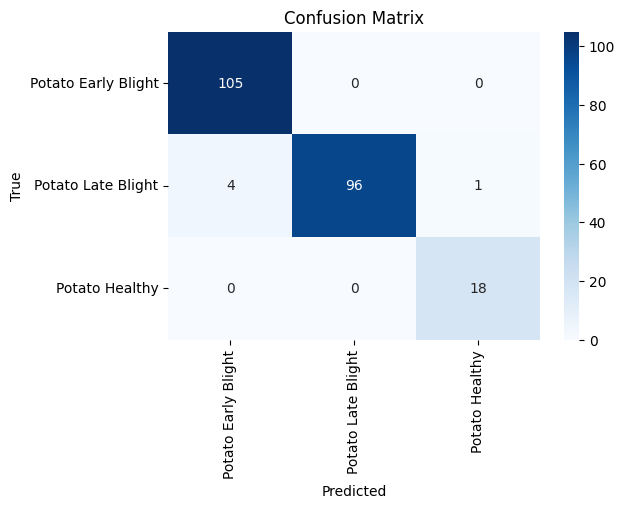

In [ ]:
# Visualize Confusion Matrix
labels = ['Potato Early Blight', 'Potato Late Blight','Potato Healthy']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate AUC-ROC
# The "ovr" means "one versus rest"
roc_auc = roc_auc_score(y_binarized, predictions, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')

AUC-ROC: 0.9997759445215971


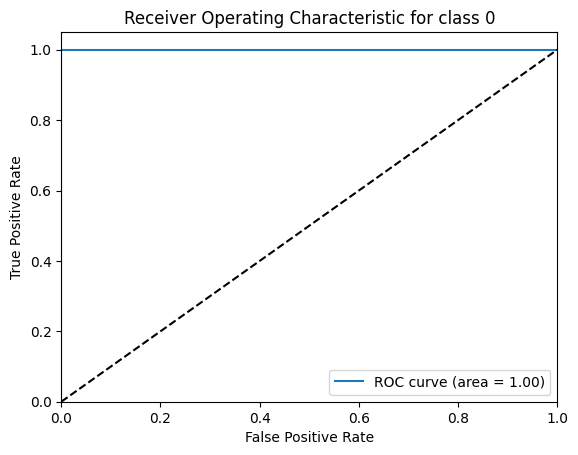

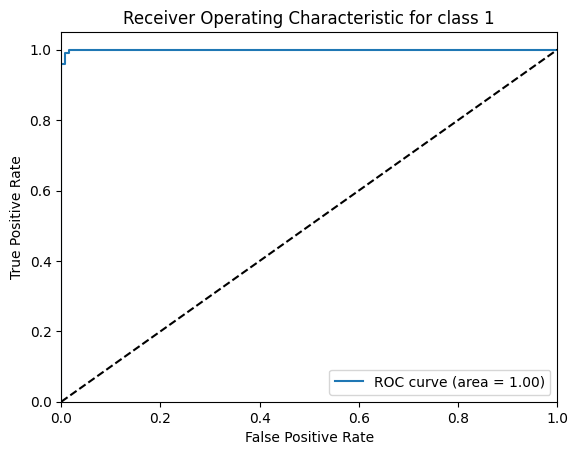

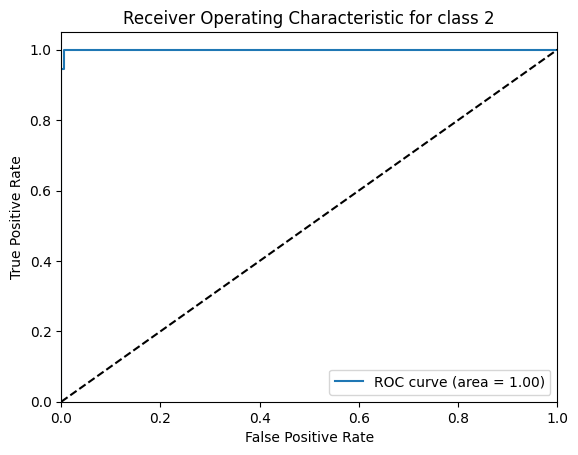

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(y_binarized[:, i], predictions[:, i])

# Plotting
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
model_path = '/content/drive/My Drive/best_model_16_DR4_001'
CNN_16_DR4_001 = tf.keras.models.load_model(model_path)

In [ ]:
scores = CNN_16_DR4_001.evaluate(test_ds)

14/14 [==============================] - 1s 78ms/step - loss: 0.0580 - accuracy: 0.9866


In [ ]:
predictions = CNN_16_DR4_001.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = []
for _, y in test_ds:
    true_labels.extend(y.numpy())

# Convert list to numpy array
true_labels = np.array(true_labels)

14/14 [==============================] - 1s 84ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Classification report for precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=['Potato Early Blight', 'Potato Late Blight', 'Potato Healthy'])
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')

                     precision    recall  f1-score   support

Potato Early Blight       0.98      1.00      0.99       105
 Potato Late Blight       1.00      0.97      0.98       101
     Potato Healthy       0.95      1.00      0.97        18

           accuracy                           0.99       224
          macro avg       0.98      0.99      0.98       224
       weighted avg       0.99      0.99      0.99       224

[[105   0   0]
 [  2  98   1]
 [  0   0  18]]
Accuracy: 0.9866071428571429


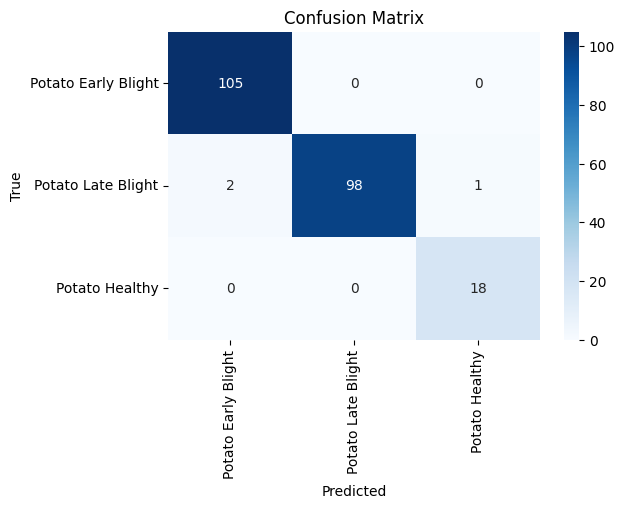

In [ ]:
# Visualize Confusion Matrix
labels = ['Potato Early Blight', 'Potato Late Blight','Potato Healthy']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate AUC-ROC
# The "ovr" means "one versus rest"
roc_auc = roc_auc_score(y_binarized, predictions, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')

AUC-ROC: 0.9998658402425608


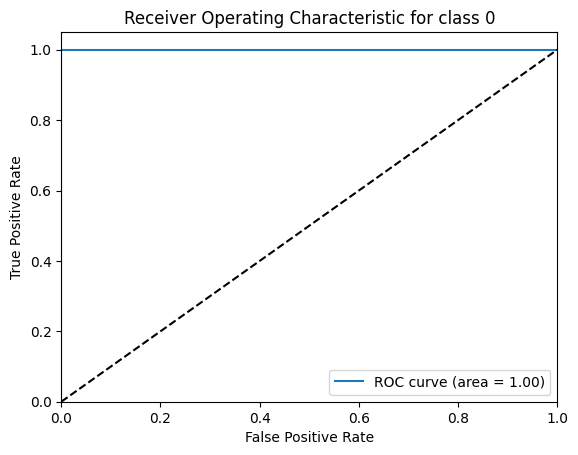

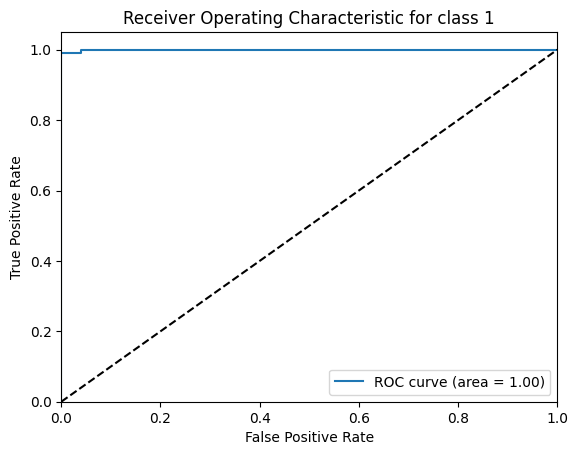

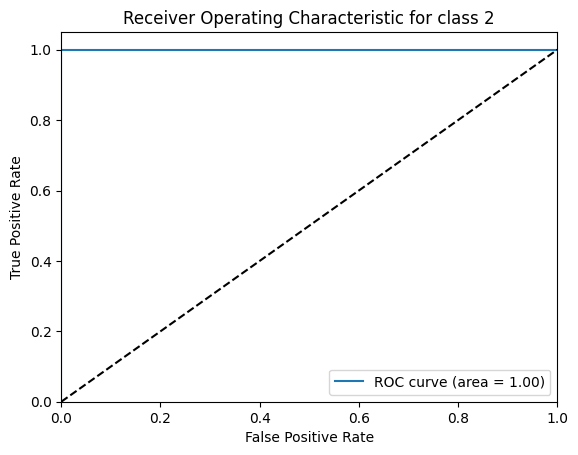

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(y_binarized[:, i], predictions[:, i])

# Plotting
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()